In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import scipy.io
from scipy.signal import lfilter,butter,filtfilt
import itertools
from scipy.stats import pearsonr
from scipy.signal import welch
#import seaborn as sns

In [3]:
nic=scipy.io.loadmat('CircuitROIsMTS/LMP_NIC_12_FP_mean_denoisedTS.mat')
data = nic['mts'].T
print(data.shape)

(29, 3890)


In [4]:
roinames = nic["roi_names"].flatten()
for name in roinames:
    print(name[0])

ACC
L_Acb
L_Amygdala
L_Amygdala_CM_Juelich50
L_Amygdala_LB_Juelich50_minus_intersect
L_Amygdala_SF_Juelich50
L_Caudate
L_FOrb
L_Hipp
L_Insula
L_MidFG
L_Pallidum
L_Putamen
L_SN_Hammersn30r83_74
L_Thalamus
R_Acb
R_Amygdala
R_Amygdala_CM_Juelich50
R_Amygdala_LB_Juelich50_minus_intersect
R_Amygdala_SF_Juelich50
R_Caudate
R_FOrb
R_Hipp
R_Insula
R_MidFG
R_Pallidum
R_Putamen
R_SN_Hammersn30r83_75
R_Thalamus


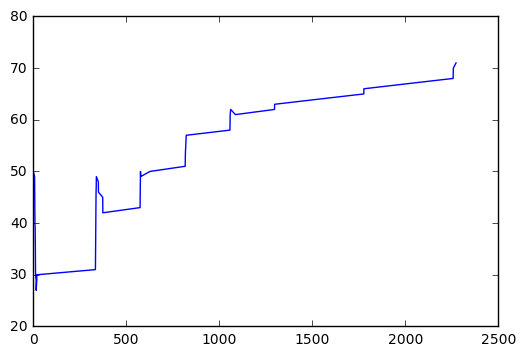

In [5]:
nict = scipy.io.loadmat('CircuitROIsMTS/LMP_NIC_12-FP/10-Apr-2017_09-57_LMP_NIC_12_FP.mat')
craving = nict['craveUpdate']
crav_t=(craving[0][0][0].T).flatten()
crav_v=(craving[0][0][1].T).flatten()
plt.plot(crav_t,crav_v)

In [6]:
# create a 10th order Butterworth filter from 0.01 to 0.1 Hz
def butter_bandpass(lowcut,highcut,fs,order=8):
    nyq = 0.5*fs
    low = lowcut/nyq
    high = highcut/nyq

    b,a = butter(order, [low, high], btype='band')
    return b,a

def butter_bandpass_filter(data,lowcut,highcut,fs,order=5):
    b,a = butter_bandpass(lowcut,highcut,fs,order=order)
    return filtfilt(b,a,data)

sampling_freq = 1/0.802
print(sampling_freq)

1.2468827930174562


/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


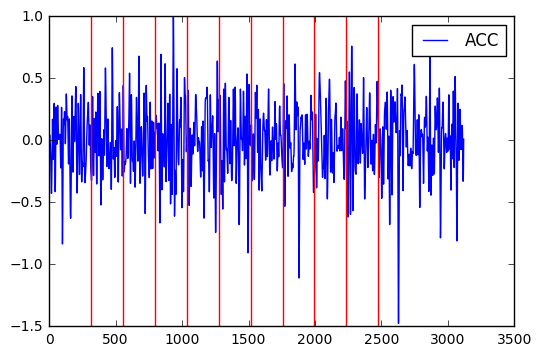

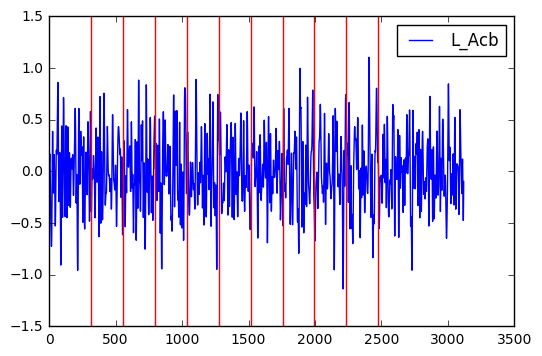

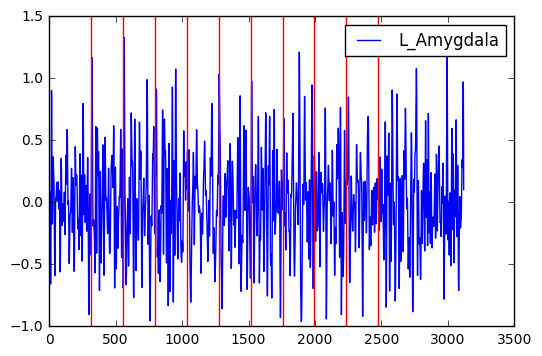

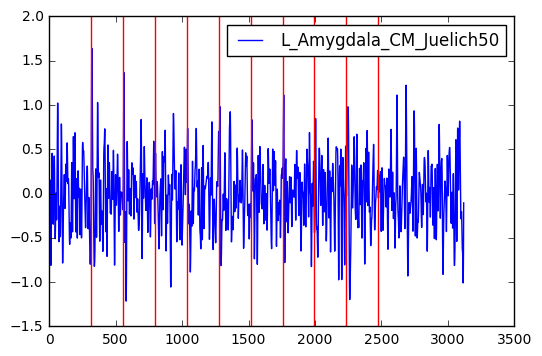

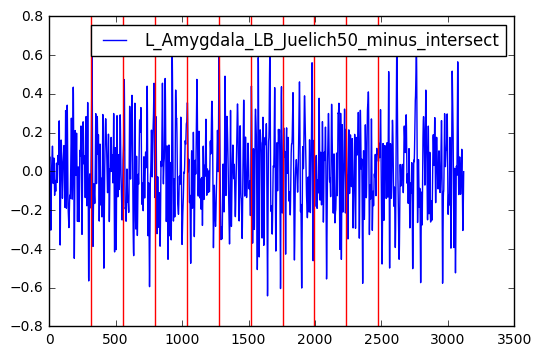

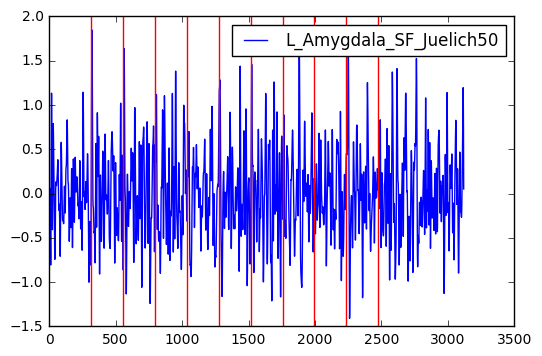

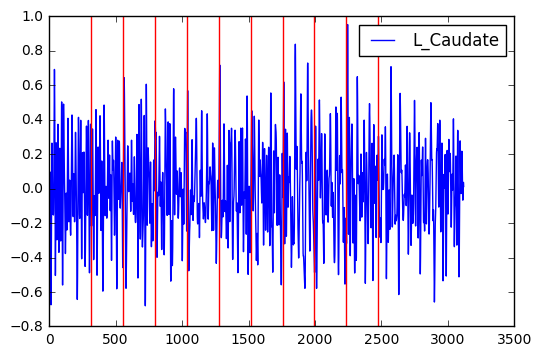

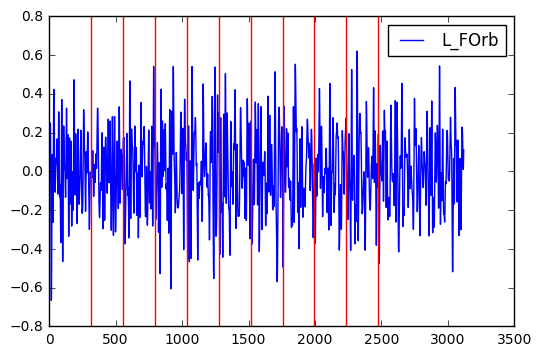

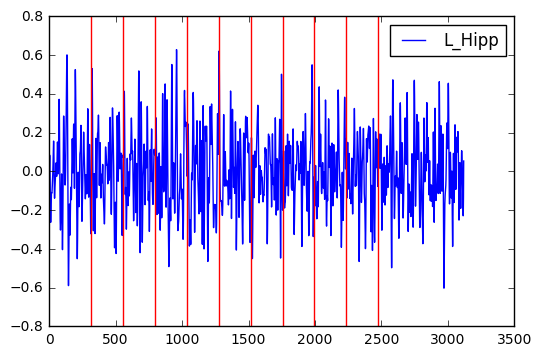

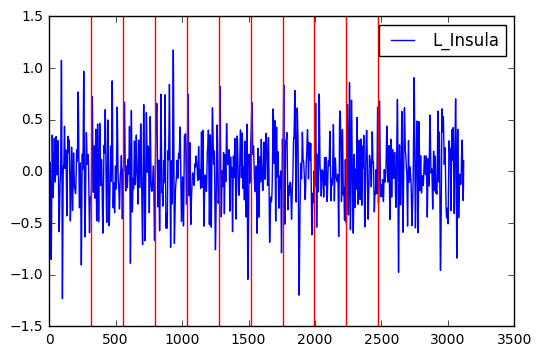

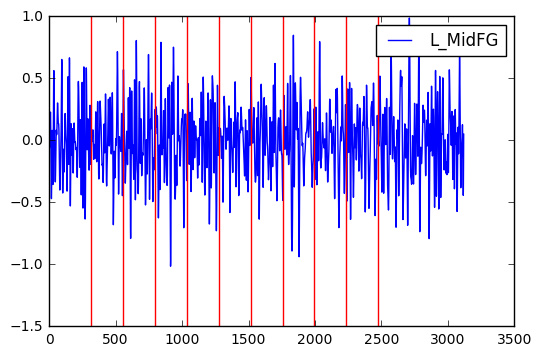

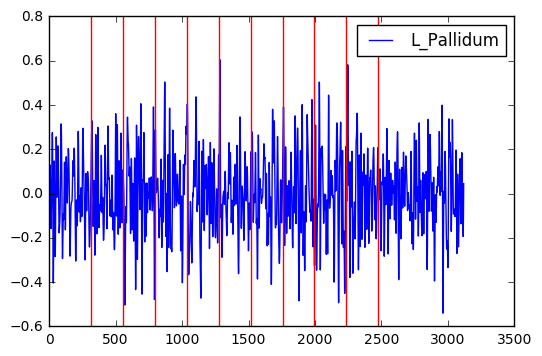

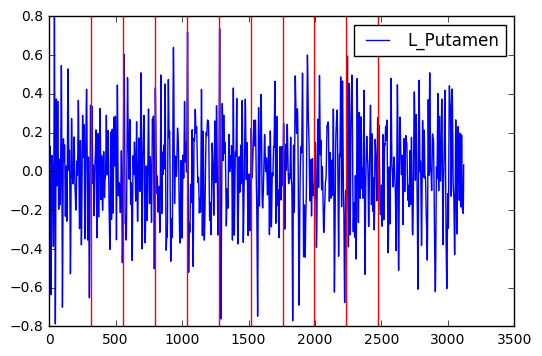

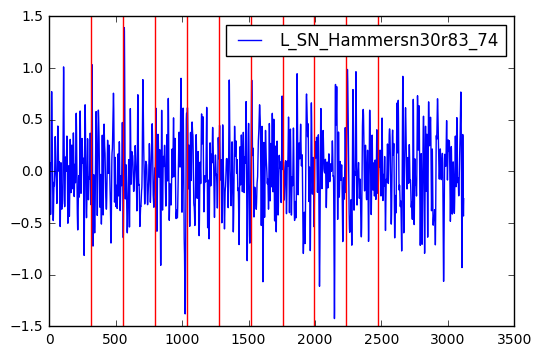

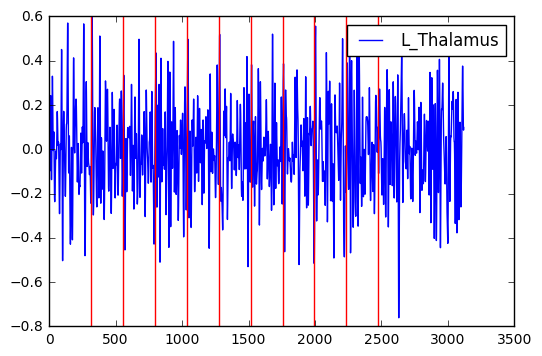

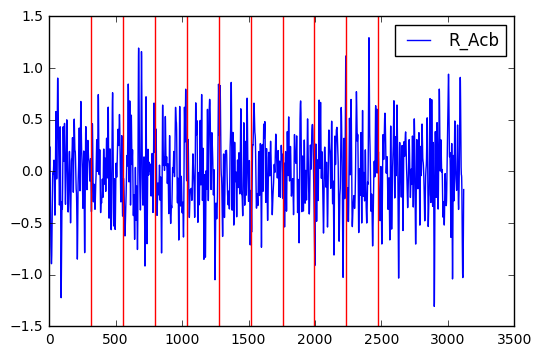

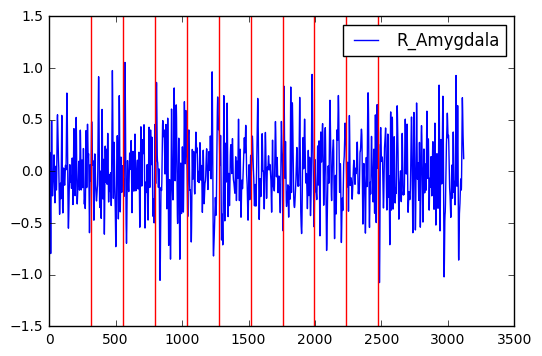

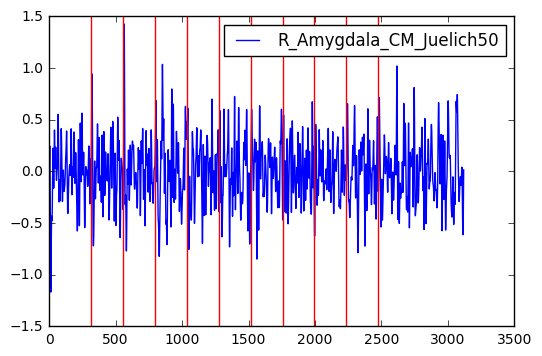

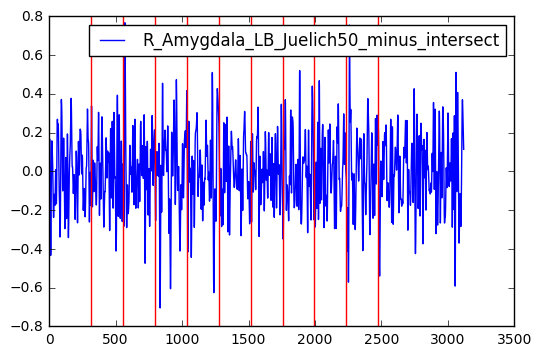

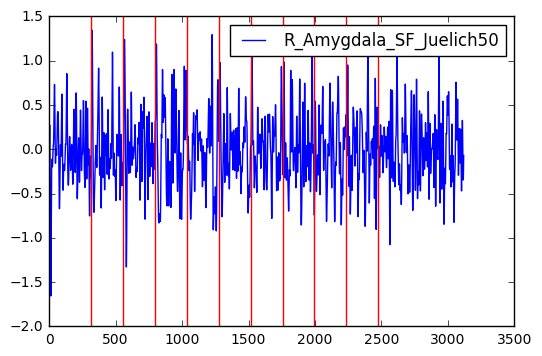

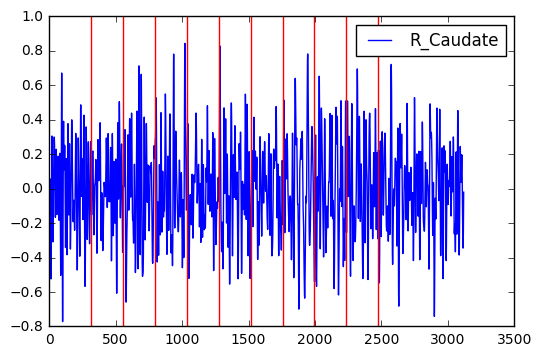

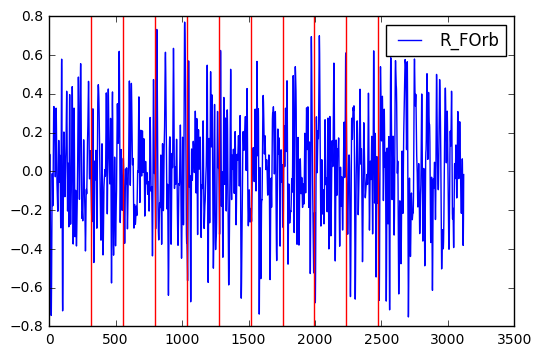

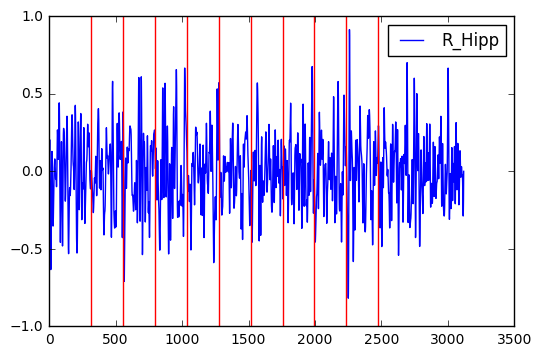

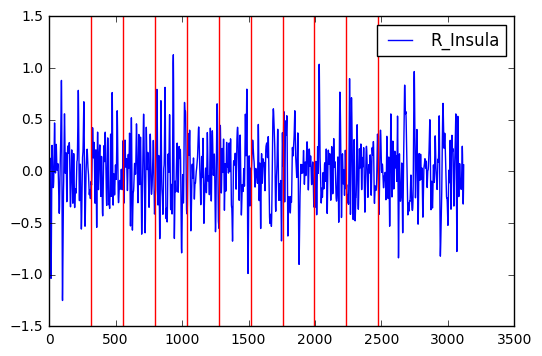

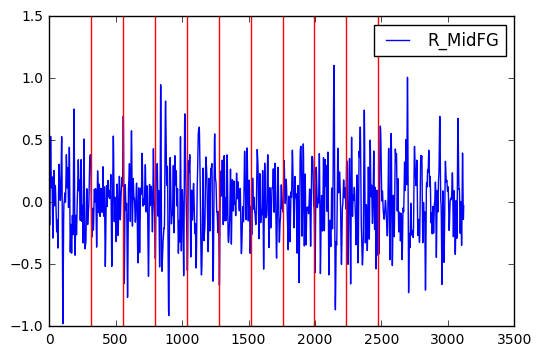

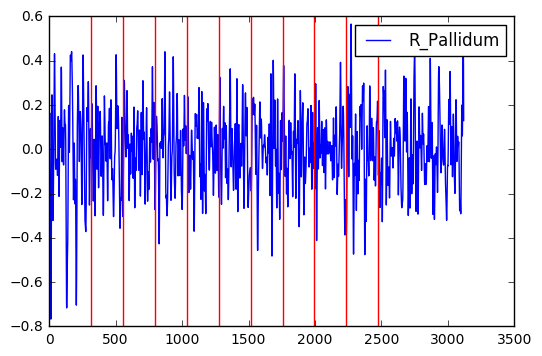

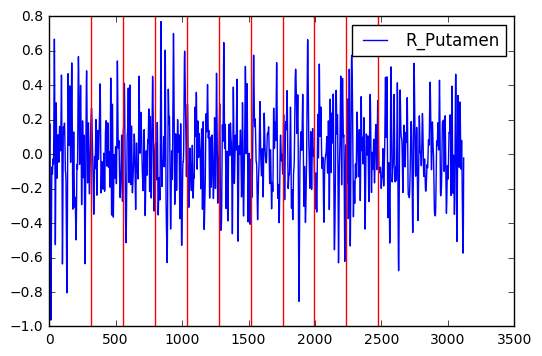

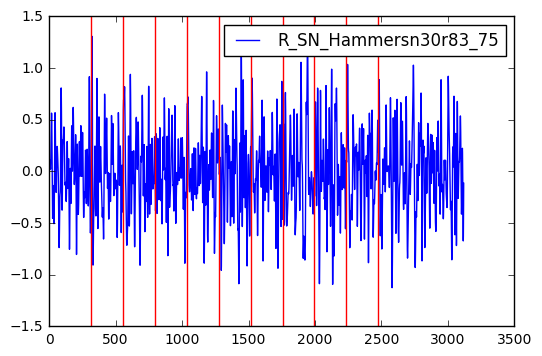

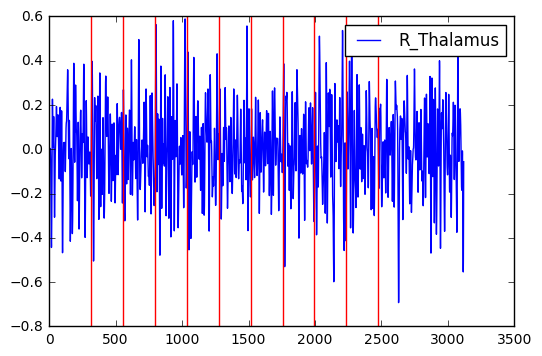

In [56]:
t = np.linspace(0,3889*.802,3890)
data_filtered = None
puffs=np.arange(316,2500,240)

for trace,name in zip(data,roinames):
    trace_filtered = butter_bandpass_filter(trace,0.01,0.1,sampling_freq,order=5)
    plt.figure()
    plt.plot(t,trace_filtered,label=name[0])
#    plt.xlim((0,1000))
    for p in puffs:
        plt.axvline(x=p,color="r")
    plt.legend()
    if data_filtered is None:
        data_filtered = trace_filtered
    else:
        data_filtered = np.vstack((data_filtered,trace_filtered))

In [8]:
data_filtered.shape

(29, 3890)

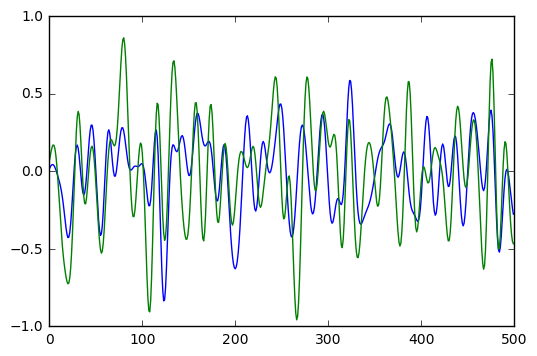

In [9]:
plt.plot(data_filtered[0][:500])
plt.plot(data_filtered[1][:500])

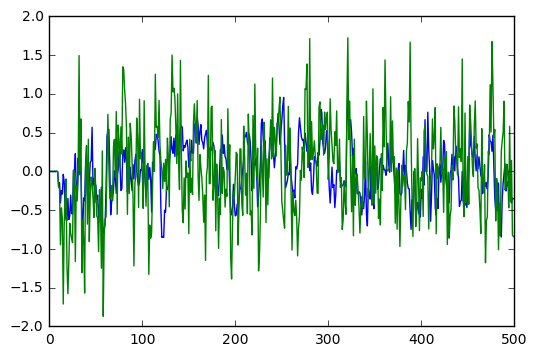

In [10]:
plt.plot(data[0][:500])
plt.plot(data[1][:500])

In [11]:
def pearson_combined(data):
    results = None
    for perm in itertools.combinations(range(data.shape[0]),2):
        pc=pearsonr(data[perm[0]],data[perm[1]])
        result=np.array([perm[0],perm[1],pc[0],pc[1]])
        if results is None:
            results = result
        else:
            results = np.vstack((results,result))
    return results
results_array = pearson_combined(data_filtered)

In [12]:
sorted_results=results_array[results_array[:,2].argsort()[::-1]]

In [13]:
for i,j,pr,pp in sorted_results:
    print(i,j,roinames[int(i)],roinames[int(j)],pr,pp)

2.0 5.0 ['L_Amygdala'] ['L_Amygdala_SF_Juelich50'] 0.897987599514 0.0
9.0 23.0 ['L_Insula'] ['R_Insula'] 0.792896776188 0.0
14.0 28.0 ['L_Thalamus'] ['R_Thalamus'] 0.78042463093 0.0
16.0 19.0 ['R_Amygdala'] ['R_Amygdala_SF_Juelich50'] 0.777353227783 0.0
12.0 26.0 ['L_Putamen'] ['R_Putamen'] 0.769029288019 0.0
6.0 20.0 ['L_Caudate'] ['R_Caudate'] 0.768740394529 0.0
16.0 18.0 ['R_Amygdala'] ['R_Amygdala_LB_Juelich50_minus_intersect'] 0.710689294977 0.0
2.0 4.0 ['L_Amygdala'] ['L_Amygdala_LB_Juelich50_minus_intersect'] 0.696609156808 0.0
8.0 22.0 ['L_Hipp'] ['R_Hipp'] 0.661524631257 0.0
0.0 28.0 ['ACC'] ['R_Thalamus'] 0.64837881558 0.0
1.0 15.0 ['L_Acb'] ['R_Acb'] 0.612347199285 0.0
0.0 14.0 ['ACC'] ['L_Thalamus'] 0.58731562227 0.0
0.0 23.0 ['ACC'] ['R_Insula'] 0.58086851679 0.0
0.0 9.0 ['ACC'] ['L_Insula'] 0.578434894861 0.0
17.0 19.0 ['R_Amygdala_CM_Juelich50'] ['R_Amygdala_SF_Juelich50'] 0.563331417547 0.0
6.0 12.0 ['L_Caudate'] ['L_Putamen'] 0.552153520042 2.17189265152e-309
4.0 5.0 [

In [14]:
def sliding_window_pearson(data1,data2,window_size,step=1):
    pr = [pearsonr(data1[index:index+window_size],data2[index:index+window_size])[0]
          for index in range(0,min(data1.size,data2.size),step)]
    pr = np.array(pr)
    return pr

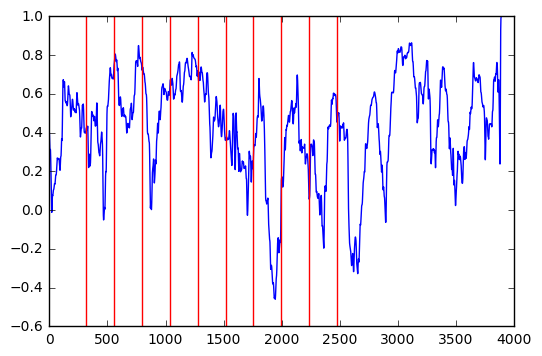

In [15]:
plt.plot(sliding_window_pearson(data_filtered[15],data_filtered[22],100))
for p in puffs:
    plt.axvline(x=p,color="r")


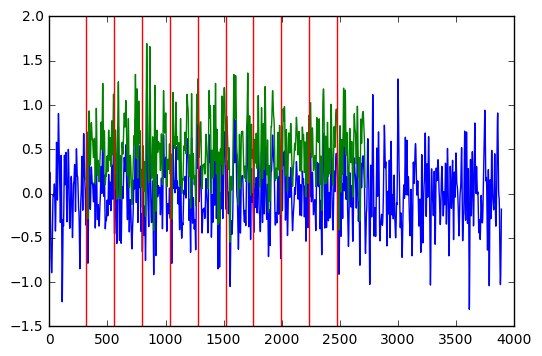

In [16]:
# new strategy:
# we compare pearson correlations of the puffs to r's from time where there is no delivery
# two time series: puffs from first puff to 2min after last puff
# nopuffs - the rest
plt.plot(range(data_filtered[15].size),data_filtered[15])
plt.plot(range(316,316+10*240+1),data_filtered[15][316:316+10*240+1]+0.5)
for p in puffs:
    plt.axvline(x=p,color="r")



In [17]:
data_puffs = data_filtered[:,316:316+10*240+1]
data_nopuffs1=data_filtered[:,:316]
data_nopuffs2=data_filtered[:,316+10*240+1:]
data_nopuffs=np.hstack((data_nopuffs1,data_nopuffs2))
print(data_puffs.shape, data_nopuffs.shape)
print(data_puffs.shape[1]+data_nopuffs.shape[1])

(29, 2401) (29, 1489)
3890


In [18]:
results_puffs = pearson_combined(data_puffs)
sorted_results_puffs=results_puffs[results_puffs[:,2].argsort()[::-1]]
for i,j,pr,pp in sorted_results_puffs:
    print(i,j,roinames[int(i)],roinames[int(j)],pr,pp)

2.0 5.0 ['L_Amygdala'] ['L_Amygdala_SF_Juelich50'] 0.909380940398 0.0
14.0 28.0 ['L_Thalamus'] ['R_Thalamus'] 0.816587311545 0.0
16.0 19.0 ['R_Amygdala'] ['R_Amygdala_SF_Juelich50'] 0.797166928578 0.0
9.0 23.0 ['L_Insula'] ['R_Insula'] 0.785468113849 0.0
6.0 20.0 ['L_Caudate'] ['R_Caudate'] 0.77727019064 0.0
12.0 26.0 ['L_Putamen'] ['R_Putamen'] 0.777133864772 0.0
16.0 18.0 ['R_Amygdala'] ['R_Amygdala_LB_Juelich50_minus_intersect'] 0.755600356102 0.0
2.0 4.0 ['L_Amygdala'] ['L_Amygdala_LB_Juelich50_minus_intersect'] 0.750460486249 0.0
8.0 22.0 ['L_Hipp'] ['R_Hipp'] 0.688026502323 0.0
0.0 28.0 ['ACC'] ['R_Thalamus'] 0.655551772089 6.26707838654e-295
1.0 15.0 ['L_Acb'] ['R_Acb'] 0.638303952225 6.39898398073e-275
0.0 14.0 ['ACC'] ['L_Thalamus'] 0.62557780052 5.83919107e-261
4.0 5.0 ['L_Amygdala_LB_Juelich50_minus_intersect'] ['L_Amygdala_SF_Juelich50'] 0.597498076076 2.40480083386e-232
17.0 19.0 ['R_Amygdala_CM_Juelich50'] ['R_Amygdala_SF_Juelich50'] 0.58810144287 2.17002583513e-223
0.0 9

In [19]:
results_nopuffs = pearson_combined(data_nopuffs)
sorted_results_nopuffs=results_nopuffs[results_nopuffs[:,2].argsort()[::-1]]
for i,j,pr,pp in sorted_results_nopuffs:
    print(i,j,roinames[int(i)],roinames[int(j)],pr,pp)

2.0 5.0 ['L_Amygdala'] ['L_Amygdala_SF_Juelich50'] 0.876351163691 0.0
9.0 23.0 ['L_Insula'] ['R_Insula'] 0.804505428649 0.0
12.0 26.0 ['L_Putamen'] ['R_Putamen'] 0.757445183132 1.29394689303e-277
6.0 20.0 ['L_Caudate'] ['R_Caudate'] 0.754904261901 1.02603278079e-274
16.0 19.0 ['R_Amygdala'] ['R_Amygdala_SF_Juelich50'] 0.74306789919 1.15236229142e-261
14.0 28.0 ['L_Thalamus'] ['R_Thalamus'] 0.72944259038 1.6617845472e-247
16.0 18.0 ['R_Amygdala'] ['R_Amygdala_LB_Juelich50_minus_intersect'] 0.639941688252 2.49619585393e-172
0.0 28.0 ['ACC'] ['R_Thalamus'] 0.637630834039 1.02155772203e-170
11.0 12.0 ['L_Pallidum'] ['L_Putamen'] 0.63131163684 2.22600283848e-166
8.0 22.0 ['L_Hipp'] ['R_Hipp'] 0.620736621733 2.43281616694e-159
9.0 12.0 ['L_Insula'] ['L_Putamen'] 0.613514315119 1.09696061834e-154
2.0 4.0 ['L_Amygdala'] ['L_Amygdala_LB_Juelich50_minus_intersect'] 0.595810118393 8.97182703533e-144
0.0 23.0 ['ACC'] ['R_Insula'] 0.59462917139 4.53682926334e-143
0.0 9.0 ['ACC'] ['L_Insula'] 0.5841

In [20]:
print(results_puffs.shape)

(406, 4)


In [21]:
results_diffp = results_puffs[:,2]-results_nopuffs[:,2]
results_diff = np.vstack((results_puffs.T,results_diffp)).T
print(results_diff.shape)

(406, 5)


In [22]:
sorted_results_diff=results_diff[results_diff[:,4].argsort()[::-1]]
for i,j,pr,pp,pd in sorted_results_diff:
    print(i,j,roinames[int(i)],roinames[int(j)],pr,pp,pd)

4.0 8.0 ['L_Amygdala_LB_Juelich50_minus_intersect'] ['L_Hipp'] 0.56967916359 1.16143406314e-206 0.264145375653
3.0 25.0 ['L_Amygdala_CM_Juelich50'] ['R_Pallidum'] 0.386485494331 2.22357215825e-86 0.259244077507
4.0 17.0 ['L_Amygdala_LB_Juelich50_minus_intersect'] ['R_Amygdala_CM_Juelich50'] 0.257247241538 1.3546846941e-37 0.240949980776
14.0 17.0 ['L_Thalamus'] ['R_Amygdala_CM_Juelich50'] 0.246480155587 1.46902917843e-34 0.223018701324
19.0 20.0 ['R_Amygdala_SF_Juelich50'] ['R_Caudate'] 0.293009114383 9.57342275991e-49 0.210677902442
14.0 15.0 ['L_Thalamus'] ['R_Acb'] 0.300131292827 3.61245632226e-51 0.200570244091
2.0 17.0 ['L_Amygdala'] ['R_Amygdala_CM_Juelich50'] 0.230952589573 1.95179894402e-30 0.200500583486
1.0 6.0 ['L_Acb'] ['L_Caudate'] 0.529508319545 1.2121108307e-173 0.1988979805
17.0 20.0 ['R_Amygdala_CM_Juelich50'] ['R_Caudate'] 0.253672271453 1.43144855231e-36 0.195136693968
1.0 25.0 ['L_Acb'] ['R_Pallidum'] 0.204807917722 3.74655958862e-24 0.187178887382
13.0 27.0 ['L_SN_

In [23]:
# now we want to look at the unfiltered data and look at the powerspectrum
data_puffs_nofilter = data[:,316:316+10*240+1]

/Users/hstrey/anaconda/envs/python3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


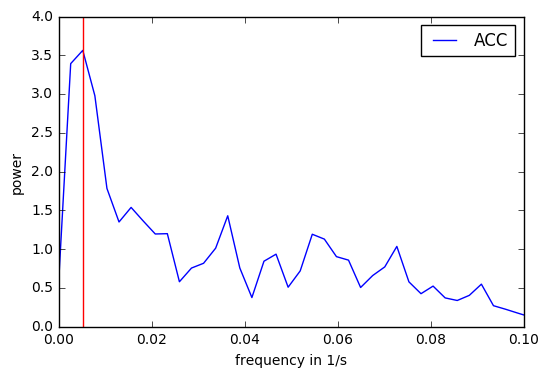

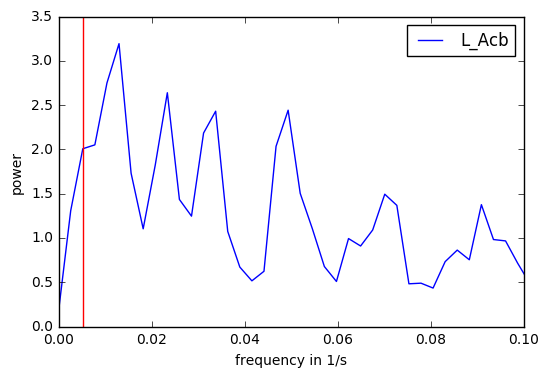

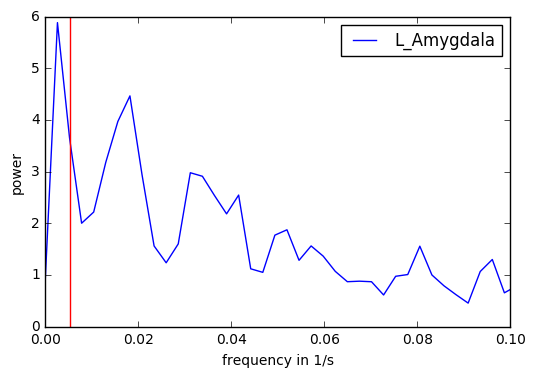

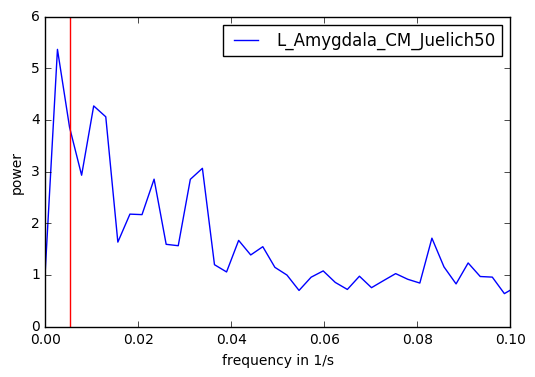

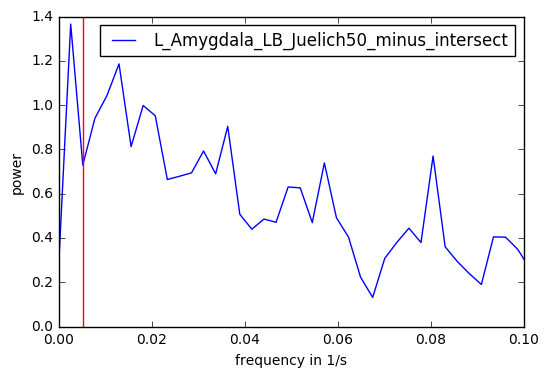

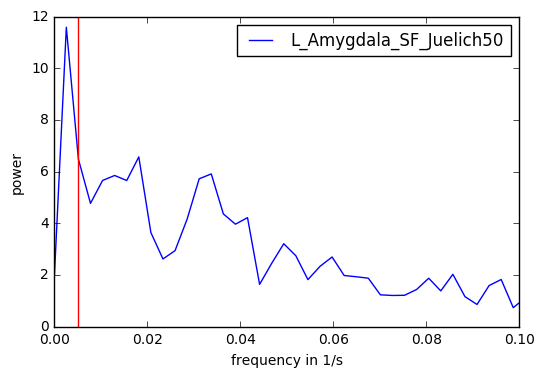

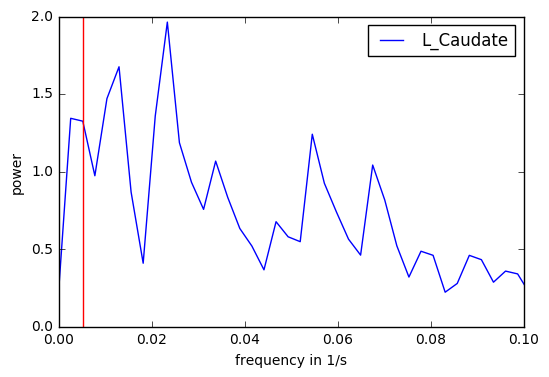

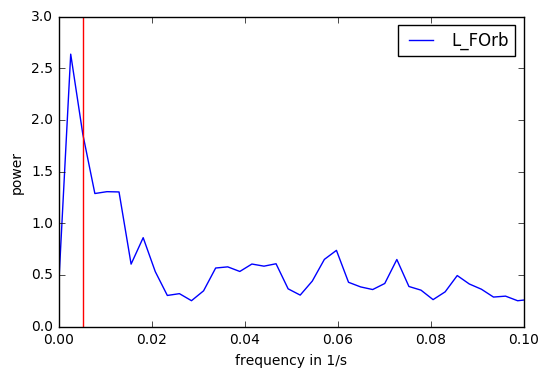

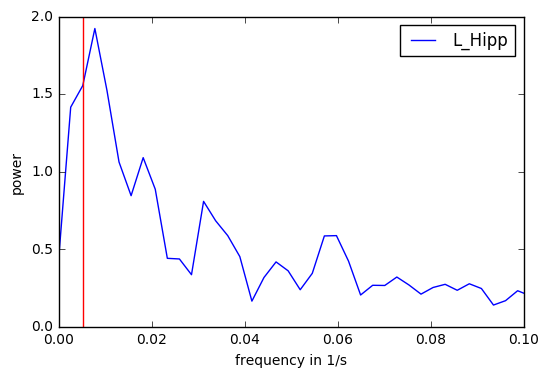

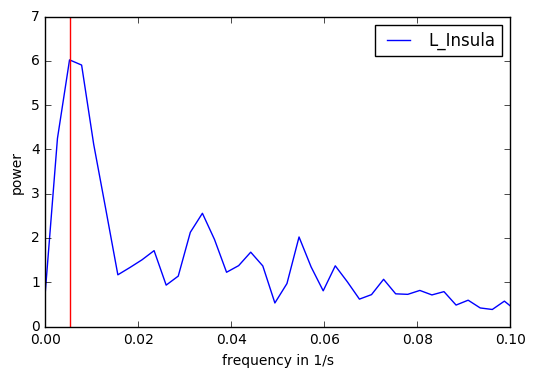

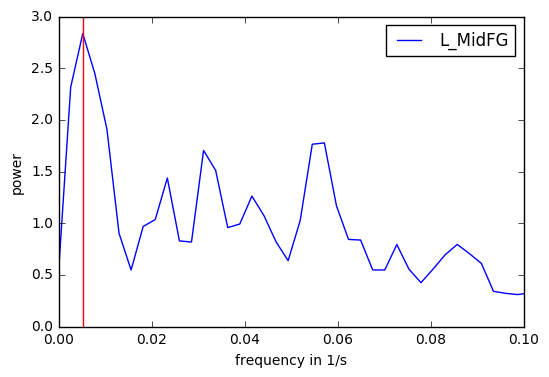

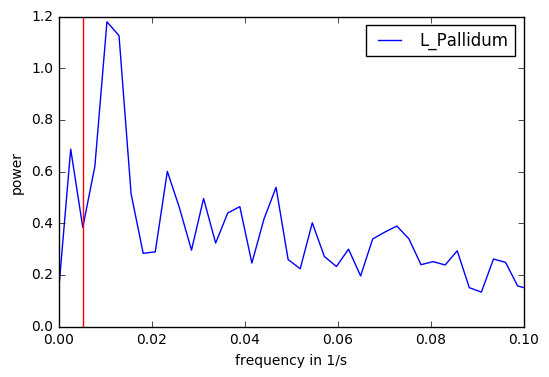

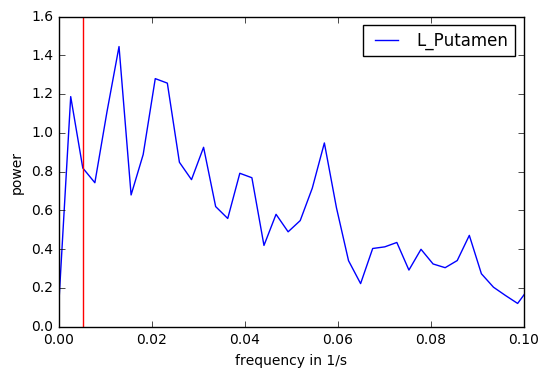

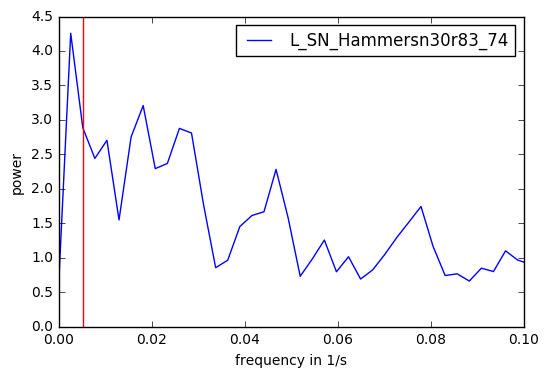

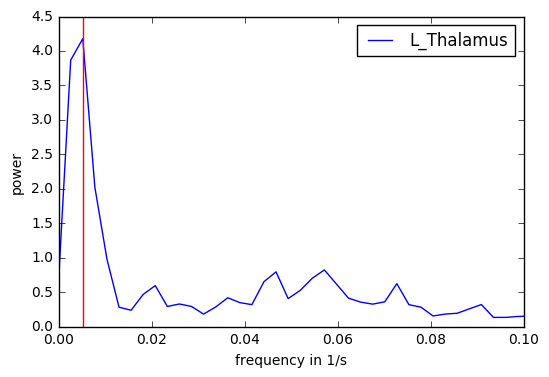

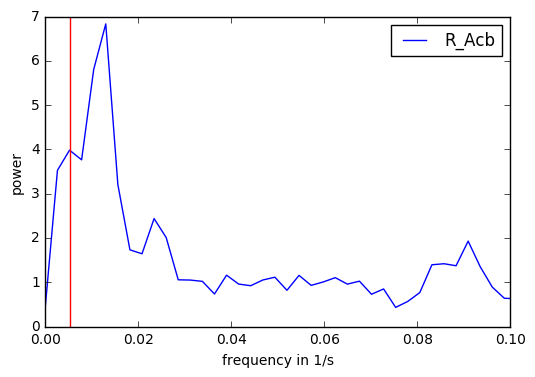

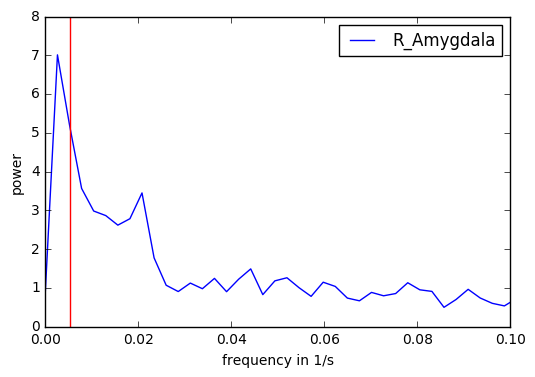

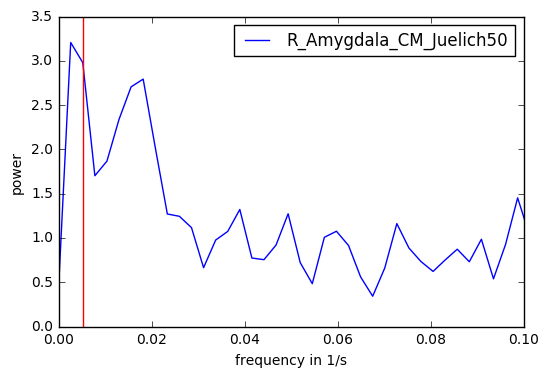

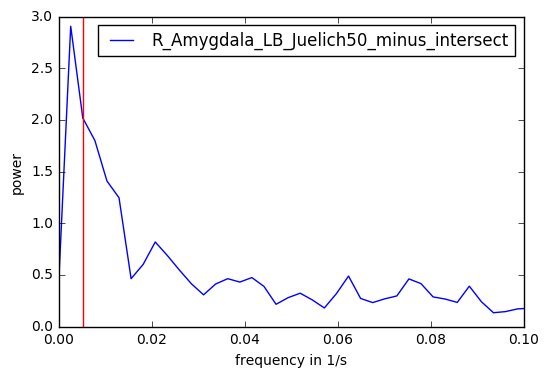

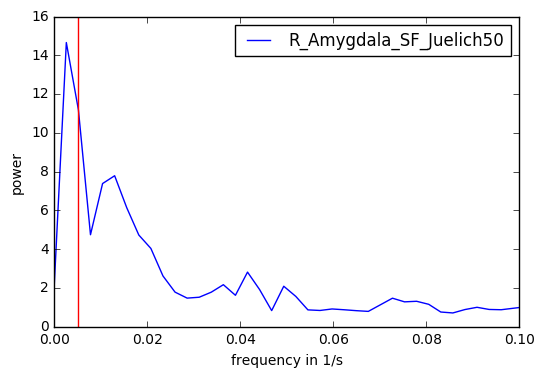

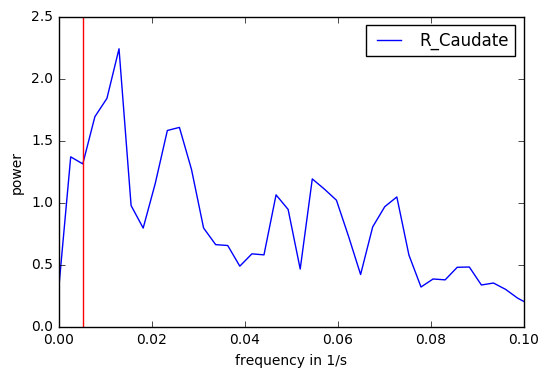

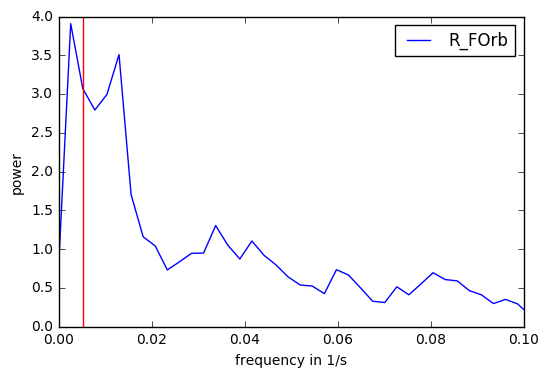

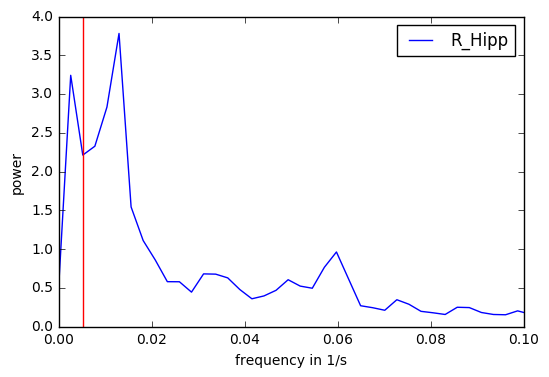

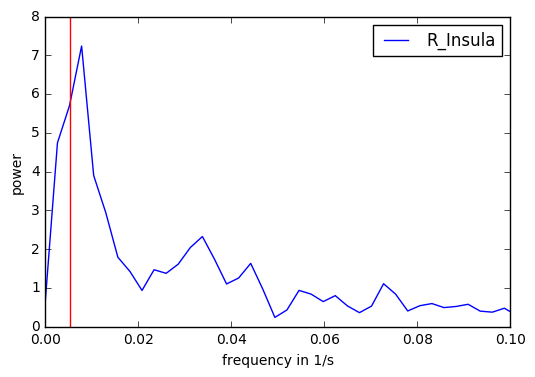

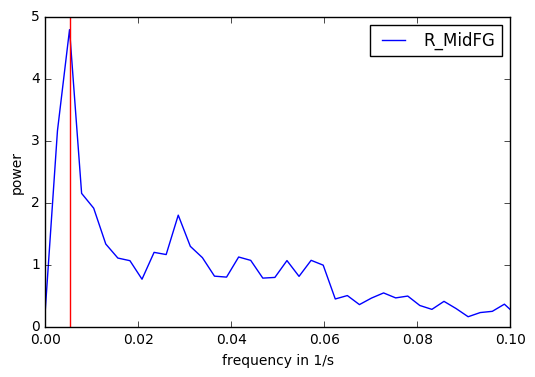

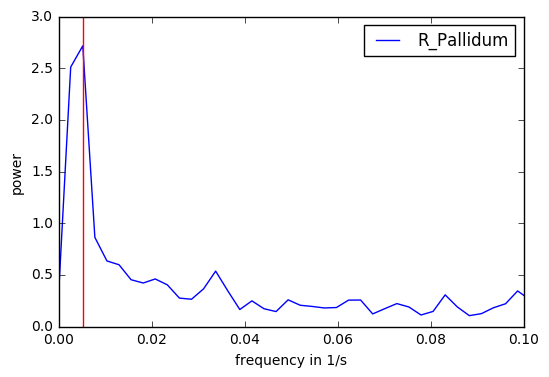

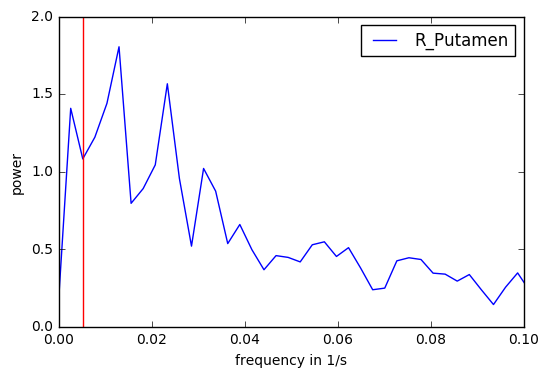

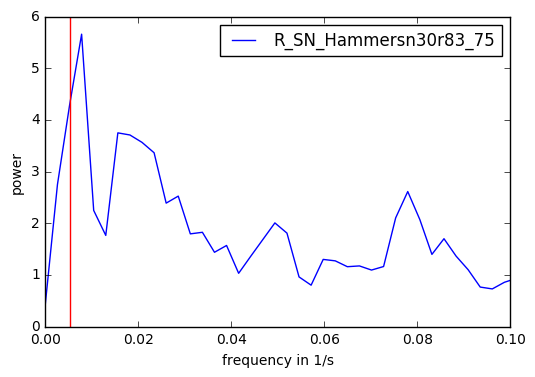

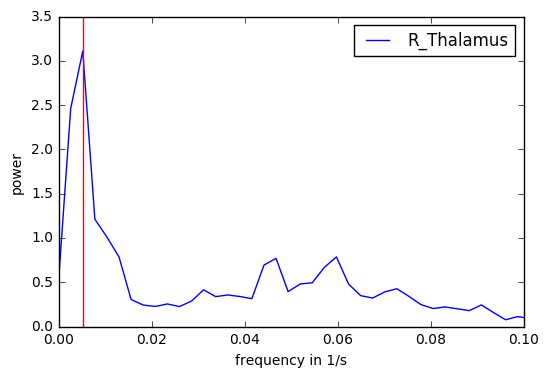

In [54]:
powerspectra = None
for region,roiname in zip(data_puffs_nofilter,roinames):
    f,ps = welch(region,fs=1/0.802,nperseg=480)
    plt.figure()
    plt.plot(f,ps,label=roiname[0])
    plt.xlim((0,0.1))
    plt.xlabel("frequency in 1/s")
    plt.ylabel("power")
    plt.axvline(x=0.00519534,color="r")
    plt.legend()
    if powerspectra is None:
        powerspectra  = ps
    else:
        powerspectra = np.vstack((powerspectra,ps))


In [44]:
print(f)

[ 0.          0.00259767  0.00519534  0.00779302  0.01039069  0.01298836
  0.01558603  0.01818371  0.02078138  0.02337905  0.02597672  0.0285744
  0.03117207  0.03376974  0.03636741  0.03896509  0.04156276  0.04416043
  0.0467581   0.04935578  0.05195345  0.05455112  0.05714879  0.05974647
  0.06234414  0.06494181  0.06753948  0.07013716  0.07273483  0.0753325
  0.07793017  0.08052785  0.08312552  0.08572319  0.08832086  0.09091854
  0.09351621  0.09611388  0.09871155  0.10130923  0.1039069   0.10650457
  0.10910224  0.11169992  0.11429759  0.11689526  0.11949293  0.12209061
  0.12468828  0.12728595  0.12988362  0.1324813   0.13507897  0.13767664
  0.14027431  0.14287199  0.14546966  0.14806733  0.150665    0.15326268
  0.15586035  0.15845802  0.16105569  0.16365337  0.16625104  0.16884871
  0.17144638  0.17404406  0.17664173  0.1792394   0.18183707  0.18443475
  0.18703242  0.18963009  0.19222776  0.19482544  0.19742311  0.20002078
  0.20261845  0.20521613  0.2078138   0.21041147  0.2

In [51]:
totalpower=np.mean(powerspectra,axis=1)
totalpower.shape

(29,)

In [52]:
for puff,pufftotal,roiname in zip(powerspectra.T[2],totalpower,roinames):
    print(puff,puff/pufftotal,roiname[0])

3.56301443763 16.3800284044 ACC
2.00682794571 3.68870142099 L_Acb
3.65170293977 6.22684891378 L_Amygdala
3.85738432905 4.88837438196 L_Amygdala_CM_Juelich50
0.728640846068 3.5309063398 L_Amygdala_LB_Juelich50_minus_intersect
6.47740068848 6.09777751722 L_Amygdala_SF_Juelich50
1.32466927547 5.68600914345 L_Caudate
1.86258940692 12.2752874682 L_FOrb
1.55446473606 10.1891753735 L_Hipp
6.02071115581 16.7602829123 L_Insula
2.83541852345 12.3358038319 L_MidFG
0.383413797842 2.08705190461 L_Pallidum
0.818046894881 4.44011605785 L_Putamen
2.88574155201 3.62978083806 L_SN_Hammersn30r83_74
4.1781904361 24.8210480389 L_Thalamus
3.98212882379 5.59711909635 R_Acb
5.19857513178 11.9147697408 R_Amygdala
2.97889351582 4.31927827445 R_Amygdala_CM_Juelich50
2.01813277576 9.953101274 R_Amygdala_LB_Juelich50_minus_intersect
11.1841440507 14.7969296043 R_Amygdala_SF_Juelich50
1.31137022922 5.59340847374 R_Caudate
3.07031163656 14.0463087324 R_FOrb
2.21176017874 10.7830995042 R_Hipp
5.70211523946 18.4929029